# Query GoogleMaps satellites tiles from given coordinates and zoom level

Some functions to retrieve GoogleMaps satellites tiles (that is to say 256x256 RGB images) from specified longitudes, latitudes and zoom levels.

Some preliminary work to a computer vision project...

Cyril Joly

In [1]:
from io import BytesIO

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
from geometry_utils import get_coordinates
from PIL import Image
from shapely.geometry import box


def download_tile(lon, lat, zoom):
    xtile, ytile = lon_lat_to_tile_coords(lon, lat, zoom)
    tile = url_to_numpy_array(get_url_coords(zoom, lon, lat))
    xmin, ymin, xmax, ymax = tile_corners(xtile, ytile, zoom)
    bounds = xmin, ymin, xmax, ymax
    xtile = url_to_numpy_array(get_url_coords(zoom=zoom, lon=lon, lat=lat))
    dx = (xmax-xmin)/256
    dy = (ymax-ymin)/256
    x = xmin+dx/2 + dx*np.arange(256)
    y = ymin+dy/2 + dy*np.arange(256)
    return x, y, tile, gpd.GeoSeries([box(*bounds)], crs=4326)


def num2deg(xtile, ytile, zoom):
    n = 1 << zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = np.arctan(np.sinh(np.pi * (1 - 2 * ytile / n)))
    lat_deg = np.degrees(lat_rad)
    return lat_deg, lon_deg


def tile_corners(xtile, ytile, zoom):
    lat_nw, lon_nw = num2deg(xtile+1, ytile+1, zoom)
    lat_se, lon_se = num2deg(xtile+0, ytile+0, zoom)
    xmin = lon_nw
    ymin = lat_se
    xmax = lon_se
    ymax = lat_nw
    return xmin, ymin, xmax, ymax


def url_to_numpy_array(url):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image_array = np.array(image)
        return image_array
    else:
        raise Exception(f"Failed to download image. Status code: {response.status_code}")


def plot(tile, extent=None, show=True):
    plt.imshow(tile, extent=extent)
    plt.axis('off')
    plt.gca().set_aspect('equal')
    if show:
        plt.show()


def deg_to_rad(degrees):
    """Convert degrees to radians."""
    return degrees * (np.pi / 180)


def lon_lat_to_tile_coords(lon, lat, zoom):
    """Convert longitude and latitude in degrees to tile coordinates."""
    n = 2 ** zoom
    xtile = n * ((lon + 180) / 360)
    lat_rad = deg_to_rad(lat)
    ytile = n * (1 - (np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi)) / 2
    return np.floor(xtile).astype(int), np.floor(ytile).astype(int)


def get_url_tiles(zoom, xtile, ytile):
    return f'https://mt1.google.com/vt/lyrs=s&x={xtile}&y={ytile}&z={zoom}'


def get_url_coords(zoom, lon, lat):
    xtile, ytile = lon_lat_to_tile_coords(lon, lat, zoom)
    return get_url_tiles(zoom, xtile, ytile)

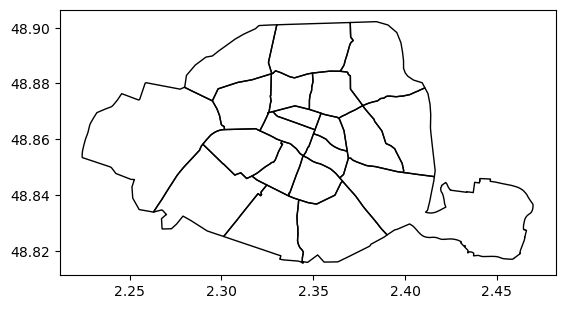

In [2]:
paris = gpd.read_file("https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/geojson?lang=fr&timezone=Europe%2FBerlin")
paris.plot(fc='none')
plt.show()

In [3]:
lon, lat = get_coordinates(place='Châtelet les Halles, Paris')
lon, lat

(2.3464427, 48.8625092)

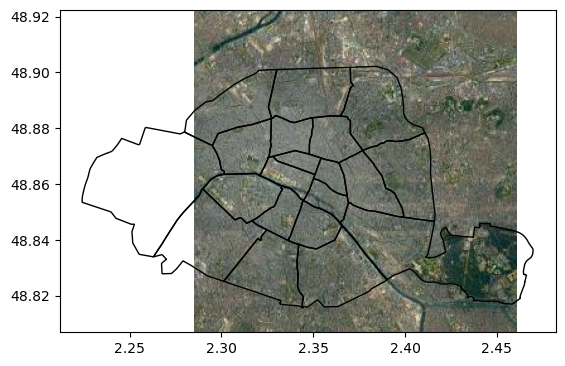

In [4]:
x, y, tile, box_tile = download_tile(lon=lon, lat=lat, zoom=11)
xmin, ymin, xmax, ymax = box_tile.total_bounds
plot(tile=tile, extent=(xmin, xmax, ymin, ymax),  show=False)

paris.plot(ax=plt.gca(), fc='none', zorder=8)
plt.gca().axis('on')
plt.show()

In [5]:
tile = url_to_numpy_array(get_url_coords(zoom=11, lon=lon, lat=lat))
tile.shape

(256, 256, 3)

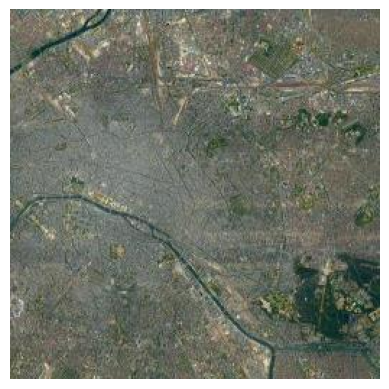

In [6]:
plot(url_to_numpy_array(get_url_coords(zoom=11, lon=lon, lat=lat)))

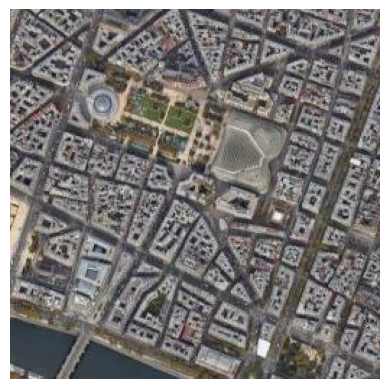

In [7]:
plot(url_to_numpy_array(get_url_coords(zoom=15, lon=lon, lat=lat)))

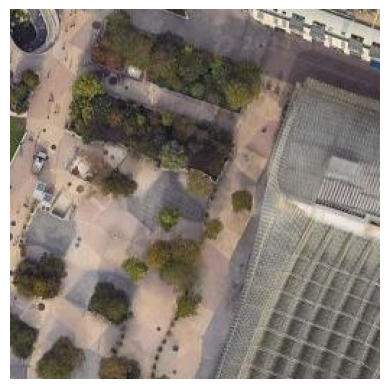

In [8]:
plot(url_to_numpy_array(get_url_coords(zoom=18, lon=lon, lat=lat)))